In [86]:
from typing import List, Set, Any, Tuple, Dict, Union
from collections.abc import Sequence

import random
from fuzzingbook.Coverage import population_coverage

In [87]:
class Mutator:
    def __init__(self) -> None:
        self.mutators = [
            self.delete_random_character,
            self.insert_random_character,
            self.flip_random_character,
        ]

In [88]:
class Mutator(Mutator):
    def insert_random_character(self, s: str) -> str:
        pos = random.randint(0, len(s))
        random_character = chr(random.randrange(32, 127))
        return s[:pos] + random_character + s[pos:]

    def delete_random_character(self, s: str) -> str:
        if s == "":
            return self.insert_random_character(s)

        pos = random.randint(0, len(s) - 1)
        return s[:pos] + s[pos + 1 :]

    def flip_random_character(self, s: str) -> str:
        if s == "":
            return self.insert_random_character

        pos = random.randint(0, len(s) - 1)
        c = s[pos]
        bit = 1 << random.randint(0, 6)
        new_c = chr(ord(c) ^ bit)

        return s[:pos] + new_c + s[pos + 1 :]

    def mutate(self, inp: Any) -> Any:
        mutator = random.choice(self.mutators)
        return mutator(inp)


Mutator().mutate("good")

'ood'

In [89]:
from fuzzingbook.Coverage import Location


class Seed:
    def __init__(self, data: str) -> None:
        self.data = data
        self.coverage: Set[Location] = set()
        self.distance: Union[int, float] = -1
        self.energy = 0.0

    def __str__(self) -> str:
        return self.data

    __repr__ = __str__

In [90]:
class PowerSchedule:
    def __init__(self) -> None:
        self.path_frequency: Dict = {}

    def assignEnergy(self, population: Sequence[Seed]) -> None:
        for seed in population:
            seed.energy = 1

    def normalizedEnergy(self, population: Sequence[Seed]) -> List[float]:
        energy = list(map(lambda seed: seed.energy, population))
        sum_energy = sum(energy)
        assert sum_energy != 0
        norm_energy = list(map(lambda nrg: nrg / sum_energy, energy))
        return norm_energy

    def choose(self, population: Sequence[Seed]) -> Seed:
        self.assignEnergy(population)
        norm_energy = self.normalizedEnergy(population)
        seed: Seed = random.choices(population, weights=norm_energy)[0]
        return seed

In [91]:
population = [Seed("A"), Seed("B"), Seed("C")]

schedule = PowerSchedule()

hits = {"A": 0, "B": 0, "C": 0}

for i in range(10000):
    seed = schedule.choose(population)
    hits[seed.data] += 1

In [92]:
hits

{'A': 3458, 'B': 3202, 'C': 3340}

In [93]:
from fuzzingbook.MutationFuzzer import FunctionCoverageRunner, http_program


def crashme(s: str) -> None:
    if len(s) > 0 and s[0] == "b":
        if len(s) > 1 and s[1] == "a":
            if len(s) > 2 and s[2] == "d":
                if len(s) > 3 and s[3] == "!":
                    raise Exception()


crashme_runner = FunctionCoverageRunner(crashme)
crashme_runner.run("good")
list(crashme_runner.coverage())

[('run_function', 410), ('crashme', 5)]

In [94]:
from fuzzingbook.Fuzzer import Fuzzer


class AdvancedMutationFuzzer(Fuzzer):
    def __init__(
        self, seeds: List[str], mutator: Mutator, schedule: PowerSchedule
    ) -> None:
        self.seeds = seeds
        self.mutator = mutator
        self.schedule = schedule
        self.inputs: List[str] = []
        self.reset()

    def reset(self) -> None:
        self.population = list(map(lambda x: Seed(x), self.seeds))
        self.seed_index = 0

    def create_candidate(self) -> str:
        seed = self.schedule.choose(self.population)
        candidate = seed.data
        trials = min(len(candidate), 1 << random.randint(1, 5))
        for i in range(trials):
            candidate = self.mutator.mutate(candidate)
        return candidate

    def fuzz(self) -> str:
        if self.seed_index < len(self.seeds):
            self.inp = self.seeds[self.seed_index]
            self.seed_index += 1
        else:
            self.inp = self.create_candidate()

        self.inputs.append(self.inp)

        return self.inp

In [95]:
seed_input = "good"
mutation_fuzzer = AdvancedMutationFuzzer([seed_input], Mutator(), PowerSchedule())
print(mutation_fuzzer.fuzz())
print(mutation_fuzzer.fuzz())
print(mutation_fuzzer.fuzz())

good
ooc%dy
go


In [96]:
import time

n = 30000

blackbox_fuzzer = AdvancedMutationFuzzer([seed_input], Mutator(), PowerSchedule())
start = time.time()
blackbox_fuzzer.runs(FunctionCoverageRunner(crashme), trials=n)
end = time.time()

In [97]:
"It took the blackbox mutation-based fuzzer %0.2f seconds to generate and execute %d inputs." % (
    end - start,
    n,
)

'It took the blackbox mutation-based fuzzer 0.51 seconds to generate and execute 30000 inputs.'

In [98]:
_, blackbox_coverage = population_coverage(blackbox_fuzzer.inputs, crashme)
bb_max_coverage = max(blackbox_coverage)
print(
    f"The blackbox mutation based fuzzer got a max coverage of {bb_max_coverage} statements"
)

The blackbox mutation based fuzzer got a max coverage of 2 statements


In [99]:
[seed_input] + [
    blackbox_fuzzer.inputs[idx]
    for idx in range(len(blackbox_coverage))
    if blackbox_coverage[idx] > blackbox_coverage[idx - 1]
]

['good', 'bo$']

In [100]:
class GreyboxFuzzer(AdvancedMutationFuzzer):
    def reset(self):
        super().reset()
        self.coverages_seen = set()
        self.population = []

    def run(self, runner: FunctionCoverageRunner) -> Tuple[Any, str]:
        result, outcome = super().run(runner)
        new_coverage = frozenset(runner.coverage())
        if new_coverage not in self.coverages_seen:
            seed = Seed(self.inp)
            seed.coverage = runner.coverage()
            self.coverages_seen.add(new_coverage)
            self.population.append(seed)

        return (result, outcome)

In [101]:
seed_input = "good"
greybox_fuzzer = GreyboxFuzzer([seed_input], Mutator(), PowerSchedule())

start = time.time()
greybox_fuzzer.runs(FunctionCoverageRunner(crashme), trials=n)
end = time.time()
print(f"Time taken by Greybox Fuzzer {end-start:.2f}, generated {n} inputs")

Time taken by Greybox Fuzzer 0.57, generated 30000 inputs


In [102]:
_, greybox_coverage = population_coverage(greybox_fuzzer.inputs, crashme)
gb_max_coverage = max(greybox_coverage)
print(f"Greybox covered {gb_max_coverage - bb_max_coverage} more statemets ")

Greybox covered 3 more statemets 


In [103]:
greybox_fuzzer.population

[good, bood"*, ba#vood"$*, bad"*, bad!"*]

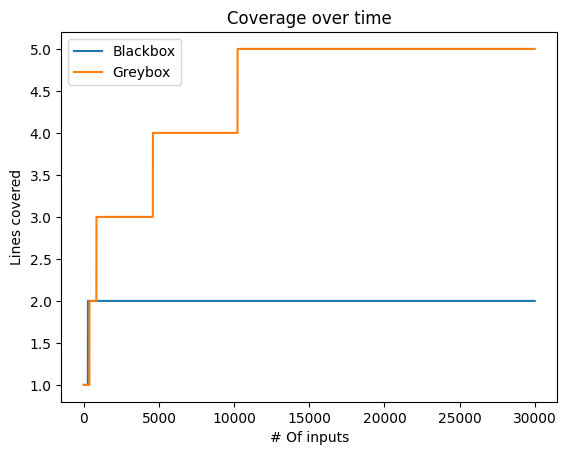

In [104]:
%matplotlib inline
import matplotlib.pyplot as plt

line_bb, = plt.plot(blackbox_coverage, label="Blackbox")
line_gb, = plt.plot(greybox_coverage, label="Greybox")

plt.legend(handles=[line_bb, line_gb])
plt.title('Coverage over time')
plt.xlabel('# Of inputs')
plt.ylabel('Lines covered')
plt.show()


In [105]:
import pickle, hashlib


def getPathID(coverage: Any) -> str:
    pickled = pickle.dumps(sorted(coverage))
    return hashlib.md5(pickled).hexdigest()

In [106]:
class AFLFastSchedule(PowerSchedule):
    def __init__(self, exponent: float) -> None:
        self.exponent = exponent

    def assignEnergy(self, population: Sequence[Seed]) -> None:
        for seed in population:
            seed.energy = 1 / (
                self.path_frequency[getPathID(seed.coverage)] ** self.exponent
            )


class CountingGreyboxFuzzer(GreyboxFuzzer):
    def reset(self):
        super().reset()
        self.schedule.path_frequency = {}

    def run(self, runner: FunctionCoverageRunner) -> Tuple[Any, str]:
        result, outcome = super().run(runner)

        path_id = getPathID(runner.coverage())
        if path_id not in self.schedule.path_frequency:
            self.schedule.path_frequency[path_id] = 1
        else:
            self.schedule.path_frequency[path_id] += 1

        return (result, outcome)


n = 10000
seed_input = "good"
fast_schedule = AFLFastSchedule(5)
fast_fuzzer = CountingGreyboxFuzzer([seed_input], Mutator(), fast_schedule)
start = time.time()
fast_fuzzer.runs(FunctionCoverageRunner(crashme), trials=n)
end = time.time()

"It took the fuzzer w/ exponential schedule %0.2f seconds to generate and execute %d inputs." % (
    end - start,
    n,
)

'It took the fuzzer w/ exponential schedule 0.43 seconds to generate and execute 10000 inputs.'

<module 'matplotlib.pyplot' from '/home/harshil/.pyenvs/fuzzing/lib/python3.11/site-packages/matplotlib/pyplot.py'>

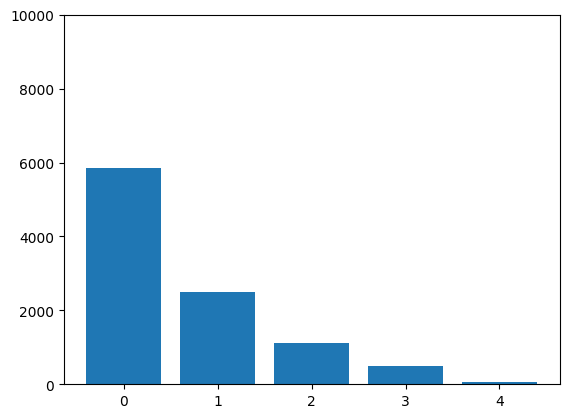

In [107]:
import numpy as np

x_axis = np.arange(len(fast_schedule.path_frequency))
y_axis = list(fast_schedule.path_frequency.values())

plt.bar(x_axis, y_axis)
plt.xticks(x_axis)
plt.ylim(0, n)
plt

In [108]:
print("             path id 'p'           : path frequency 'f(p)'")
fast_schedule.path_frequency

             path id 'p'           : path frequency 'f(p)'


{'f1bc2f03020c9cfa40ef926855aa2272': 5846,
 '44455a9bdbeef103dcdf39eb0614386f': 2488,
 '11c535c3525708675737c4f60335ec99': 1123,
 '3cdffdcf11ad785bb46869435d59c204': 483,
 'b58f7b3918bc4c35c007bc69e3f34786': 60}

In [109]:
seed_input = "good"
orig_schedule = PowerSchedule()
orig_fuzzer = CountingGreyboxFuzzer([seed_input], Mutator(), orig_schedule)
start = time.time()
orig_fuzzer.runs(FunctionCoverageRunner(crashme), trials=n)
end = time.time()

"It took the fuzzer w/ original schedule %0.2f seconds to generate and execute %d inputs." % (
    end - start,
    n,
)

'It took the fuzzer w/ original schedule 0.25 seconds to generate and execute 10000 inputs.'

<module 'matplotlib.pyplot' from '/home/harshil/.pyenvs/fuzzing/lib/python3.11/site-packages/matplotlib/pyplot.py'>

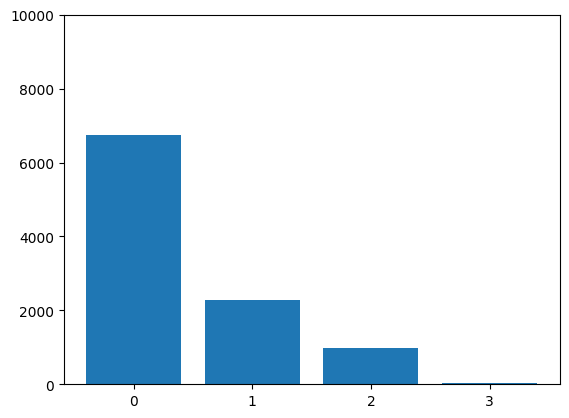

In [110]:
x_axis = np.arange(len(orig_schedule.path_frequency))
y_axis = list(orig_schedule.path_frequency.values())

plt.bar(x_axis, y_axis)
plt.xticks(x_axis)
plt.ylim(0, n)
# plt.yscale("log")
# plt.yticks([10,100,1000,10000])
plt

In [111]:
print("             path id 'p'           : path frequency 'f(p)'")
orig_schedule.path_frequency

             path id 'p'           : path frequency 'f(p)'


{'f1bc2f03020c9cfa40ef926855aa2272': 6742,
 '44455a9bdbeef103dcdf39eb0614386f': 2267,
 '11c535c3525708675737c4f60335ec99': 969,
 '3cdffdcf11ad785bb46869435d59c204': 22}

In [112]:
orig_energy = orig_schedule.normalizedEnergy(orig_fuzzer.population)
for seed, norm_energy in zip(orig_fuzzer.population, orig_energy):
    print("'%s', %0.5f, %s" % (getPathID(seed.coverage), norm_energy, repr(seed.data)))

'f1bc2f03020c9cfa40ef926855aa2272', 0.25000, 'good'
'44455a9bdbeef103dcdf39eb0614386f', 0.25000, 'b&>ood'
'11c535c3525708675737c4f60335ec99', 0.25000, 'ba&6oodl$:'
'3cdffdcf11ad785bb46869435d59c204', 0.25000, 'bad'


Text(0, 0.5, 'lines covered')

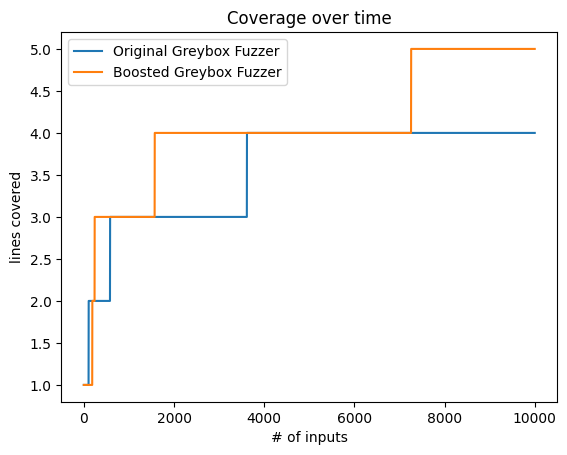

In [113]:
_, orig_coverage = population_coverage(orig_fuzzer.inputs, crashme)
_, fast_coverage = population_coverage(fast_fuzzer.inputs, crashme)

(line_orig,) = plt.plot(orig_coverage, label="Original Greybox Fuzzer")
(line_fast,) = plt.plot(fast_coverage, label="Boosted Greybox Fuzzer")

plt.legend(handles=[line_orig, line_fast])
plt.title("Coverage over time")
plt.xlabel("# of inputs")
plt.ylabel("lines covered")

In [114]:
from html.parser import HTMLParser


def my_parser(inp: str) -> None:
    parser = HTMLParser()
    parser.feed(inp)


n = 5000
seed_input = " "
blackbox_fuzzer = AdvancedMutationFuzzer([seed_input], Mutator(), PowerSchedule())
greybox_fuzzer = GreyboxFuzzer([seed_input], Mutator(), PowerSchedule())
boosted_fuzzer = CountingGreyboxFuzzer([seed_input], Mutator(), AFLFastSchedule(5))

start = time.time()
blackbox_fuzzer.runs(FunctionCoverageRunner(my_parser), trials=n)
greybox_fuzzer.runs(FunctionCoverageRunner(my_parser), trials=n)
boosted_fuzzer.runs(FunctionCoverageRunner(my_parser), trials=n)
end = time.time()

"It took all three fuzzers %0.2f seconds to generate and execute %d inputs." % (
    end - start,
    n,
)

'It took all three fuzzers 27.47 seconds to generate and execute 5000 inputs.'

Text(0, 0.5, 'lines covered')

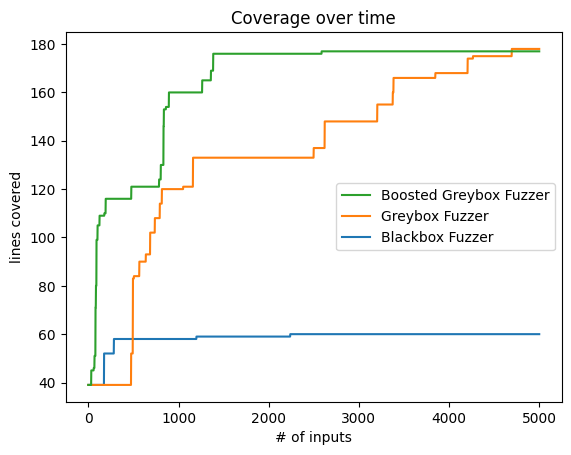

In [115]:
_, black_coverage = population_coverage(blackbox_fuzzer.inputs, my_parser)
_, grey_coverage = population_coverage(greybox_fuzzer.inputs, my_parser)
_, boost_coverage = population_coverage(boosted_fuzzer.inputs, my_parser)
(line_black,) = plt.plot(black_coverage, label="Blackbox Fuzzer")
(line_grey,) = plt.plot(grey_coverage, label="Greybox Fuzzer")
(line_boost,) = plt.plot(boost_coverage, label="Boosted Greybox Fuzzer")
plt.legend(handles=[line_boost, line_grey, line_black])
plt.title("Coverage over time")
plt.xlabel("# of inputs")
plt.ylabel("lines covered")

In [116]:
blackbox_fuzzer.inputs[-10:]

[' <', '(', '', '', "' ", '`', '', 'c ', ' \\', '!']

In [117]:
greybox_fuzzer.inputs[-10:]

['kU~<RU\x00\x1c',
 '&4\x7f(<s',
 ')#&</5%',
 '4%',
 ':dBV</XC`q>{?<b',
 '5\x12[\x05H&&D2:v',
 '=>',
 '9U6~<L<\\R\x15&F\x06V<I',
 '<7[v%e}&',
 ':dB~<!jX5Cr>\x1c2b']

In [118]:
from fuzzingbook.ControlFlow import generate_maze_code

maze_string = """
+-+-----+
|X|     |
| | --+ |
| |   | |
| +-- | |
|     |#|
+-----+-+
"""
maze_code = generate_maze_code(maze_string)

exec(maze_code)

In [119]:
print(maze("DDDDRRRRUULLUURRRRDDDD"))

SOLVED

+-+-----+
| |     |
| | --+ |
| |   | |
| +-- | |
|     |X|
+-----+-+



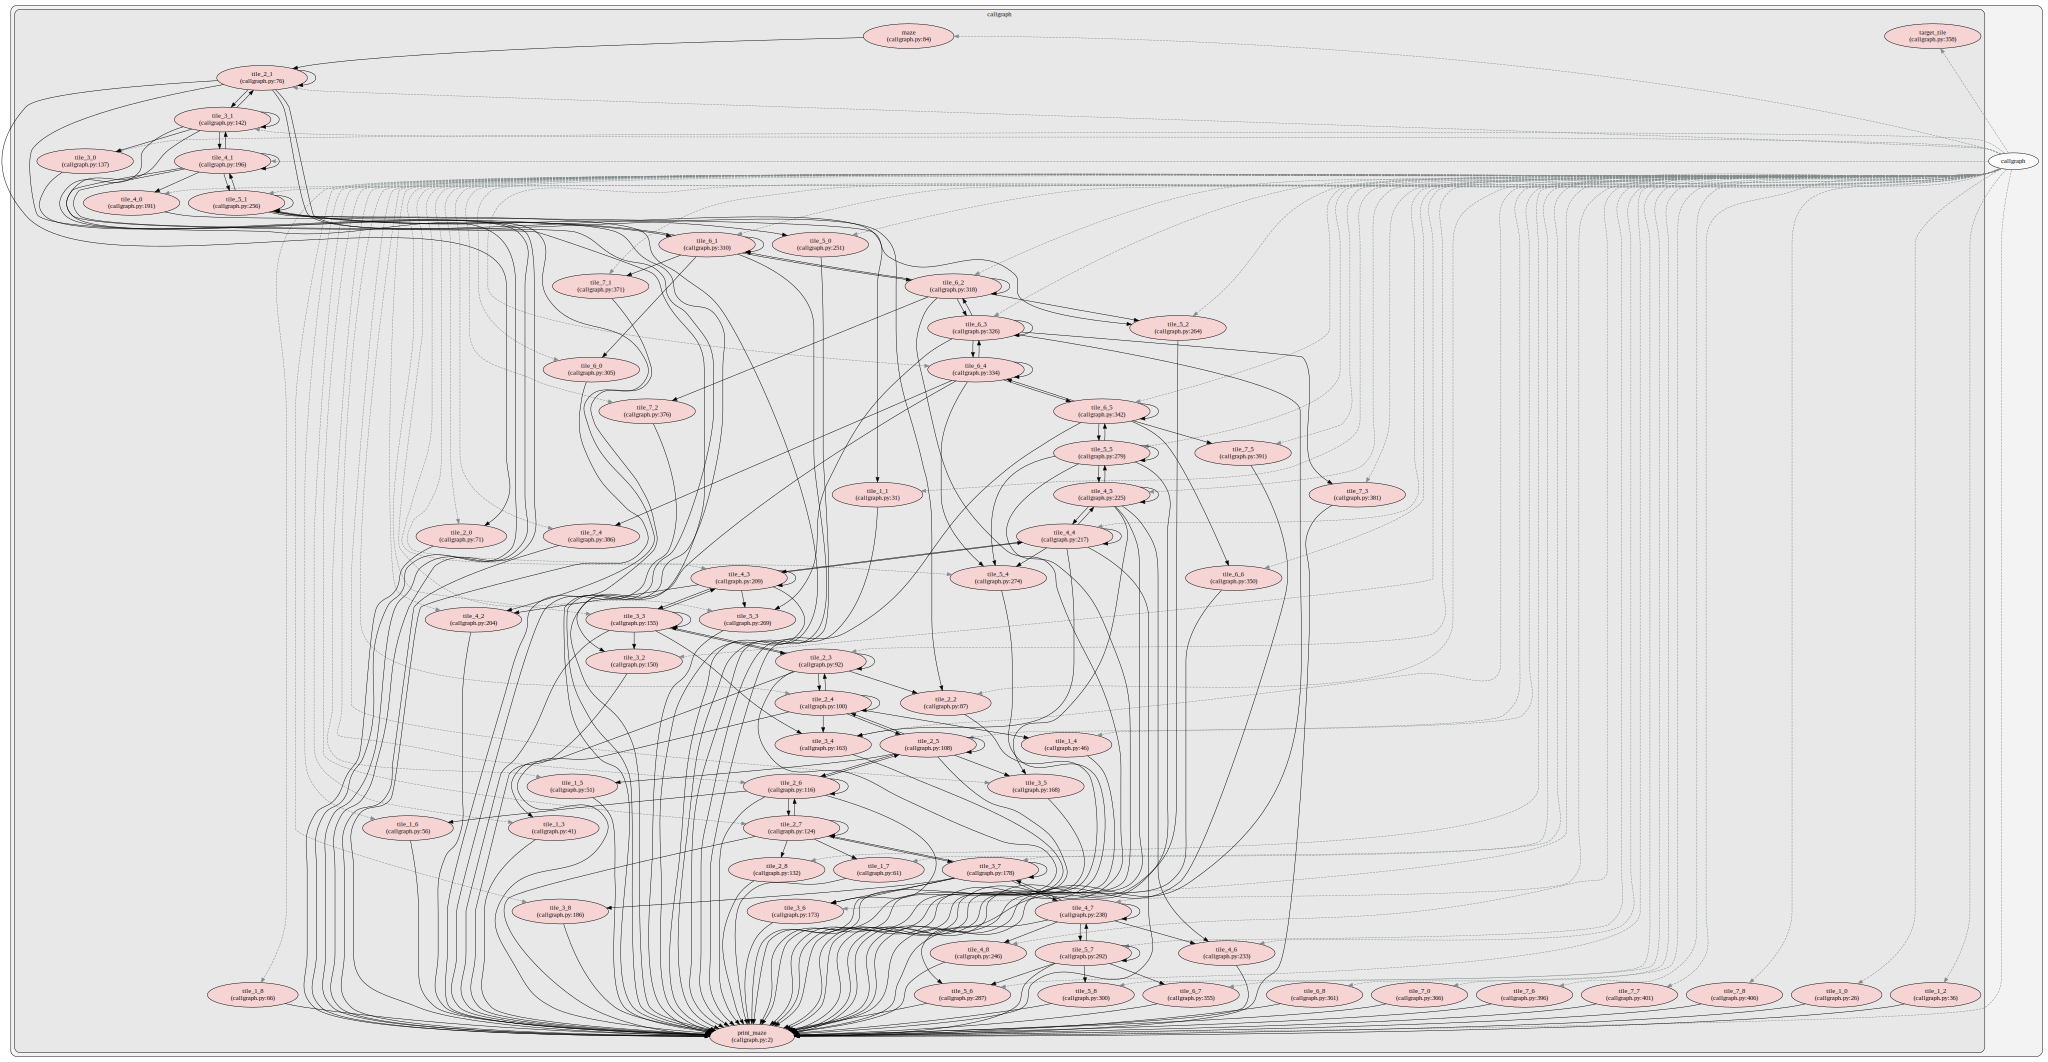

In [120]:
from fuzzingbook.ControlFlow import callgraph

callgraph(maze_code)

In [121]:
class DictMutator(Mutator):
    def __init__(self, dictionary: Sequence[str]) -> None:
        super().__init__()
        self.dictionary = dictionary
        self.mutators.append(self.insert_from_dictionary)

    def insert_from_dictionary(self, s: str) -> str:
        pos = random.randint(0, len(s))
        random_keyword = random.choice(self.dictionary)
        return s[:pos] + random_keyword + s[pos:]


class MazeMutator(DictMutator):
    def __init__(self, dictionary: Sequence[str]) -> None:
        super().__init__(dictionary=dictionary)
        self.mutators.append(self.delete_last_character)
        self.mutators.append(self.append_from_dictionary)

    def append_from_dictionary(self, s: str) -> str:
        random_keyword = random.choice(self.dictionary)
        return s + random_keyword

    def delete_last_character(self, s: str) -> str:
        if len(s) > 0:
            return s[:-1]
        return s

In [122]:
n = 20000
seed_input = " "
maze_mutator = MazeMutator(["L", "R", "U", "D"])
maze_schedule = PowerSchedule()
maze_fuzzer = GreyboxFuzzer([seed_input], maze_mutator, maze_schedule)

start = time.time()
maze_fuzzer.runs(FunctionCoverageRunner(maze), trials=n)
end = time.time()

"It took the fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer 10.19 seconds to generate and execute 20000 inputs.'

In [123]:
def print_stats(fuzzer: GreyboxFuzzer) -> None:
    total = len(fuzzer.population)
    solved = 0
    invalid = 0
    valid = 0
    for seed in fuzzer.population:
        s = maze(str(seed.data))
        if "INVALID" in s:
            invalid += 1
        elif "VALID" in s:
            valid += 1
        elif "SOLVED" in s:
            solved += 1
            if solved == 1:
                print("First solution: %s" % repr(seed))
        else:
            print("??")

    print(
        """Out of %d seeds,
* %4d solved the maze,
* %4d were valid but did not solve the maze, and
* %4d were invalid"""
        % (total, solved, valid, invalid)
    )

In [124]:
print_stats(maze_fuzzer)

Out of 1721 seeds,
*    0 solved the maze,
*  425 were valid but did not solve the maze, and
* 1296 were invalid


In [125]:
maze_schedule = AFLFastSchedule(5)
seed_input = " "
maze_mutator = MazeMutator(["L", "R", "U", "D"])
maze_fuzzer = CountingGreyboxFuzzer([seed_input], maze_mutator, maze_schedule)
maze_runner = FunctionCoverageRunner(maze)
maze_fuzzer.runs(maze_runner, trials=5000)
print_stats(maze_fuzzer)

Out of 775 seeds,
*    0 solved the maze,
*  202 were valid but did not solve the maze, and
*  573 were invalid


In [126]:
target = target_tile()
target

import networkx as nx
from fuzzingbook.ControlFlow import get_callgraph

cg = get_callgraph(maze_code)
for node in cg.nodes():
    if target in node:
        target_node = node
        break

target_node

'callgraphX__tile_6_7'

In [127]:
distance = {}
for node in cg.nodes():
    if "__" in node:
        name = node.split("__")[-1]
    else:
        name = node
    try:
        distance[name] = nx.shortest_path_length(cg, node, target_node)
    except:
        distance[name] = 0xFFFF

In [128]:
{k: distance[k] for k in list(distance) if distance[k] < 0xFFFF}

{'callgraphX': 1,
 'maze': 23,
 'tile_2_1': 22,
 'tile_2_3': 8,
 'tile_2_4': 7,
 'tile_2_5': 6,
 'tile_2_6': 5,
 'tile_2_7': 4,
 'tile_3_1': 21,
 'tile_3_3': 9,
 'tile_3_7': 3,
 'tile_4_1': 20,
 'tile_4_3': 10,
 'tile_4_4': 11,
 'tile_4_5': 12,
 'tile_4_7': 2,
 'tile_5_1': 19,
 'tile_5_5': 13,
 'tile_5_7': 1,
 'tile_6_1': 18,
 'tile_6_2': 17,
 'tile_6_3': 16,
 'tile_6_4': 15,
 'tile_6_5': 14,
 'tile_6_7': 0}

In [129]:
class DirectedSchedule(PowerSchedule):
    def __init__(self, distance: Dict[str, int], exponent: float) -> None:
        self.distance = distance
        self.exponent = exponent

    def __getFunctions__(self, coverage: Set[Location]) -> Set[str]:
        functions = set()
        for f, _ in set(coverage):
            functions.add(f)
        return functions

    def assignEnergy(self, population: Sequence[Seed]) -> None:
        for seed in population:
            if seed.distance < 0:
                num_dist = 0
                sum_dist = 0

                for f in self.__getFunctions__(seed.coverage):
                    if f in list(self.distance):
                        sum_dist += self.distance[f]
                        num_dist += 1
                seed.distance = sum_dist / num_dist
                seed.energy = (1 / seed.distance) ** self.exponent

In [130]:
directed_schedule = DirectedSchedule(distance, 3)
directed_fuzzer = GreyboxFuzzer([seed_input], maze_mutator, directed_schedule)
start = time.time()
directed_fuzzer.runs(FunctionCoverageRunner(maze), trials=n)
end = time.time()

"It took the fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer 15.08 seconds to generate and execute 20000 inputs.'

In [131]:
print_stats(directed_fuzzer)

Out of 2694 seeds,
*    0 solved the maze,
* 1000 were valid but did not solve the maze, and
* 1694 were invalid


Text(0, 0.5, 'Distance')

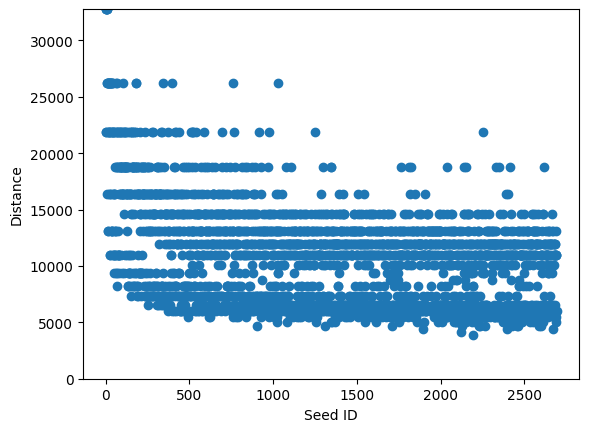

In [132]:
y = [seed.distance for seed in directed_fuzzer.population]
x = range(len(y))
plt.scatter(x, y)
plt.ylim(0, max(y))
plt.xlabel("Seed ID")
plt.ylabel("Distance")

In [133]:
class AFLGoSchedule(DirectedSchedule):
    def assignEnergy(self, population: Sequence[Seed]):
        min_dist: Union[int, float] = 0xFFFF
        max_dist: Union[int, float] = 0

        for seed in population:
            if seed.distance < 0:
                num_dist = 0
                sum_dist = 0
                for f in self.__getFunctions__(seed.coverage):
                    if f in list(self.distance):
                        sum_dist += self.distance[f]
                        num_dist += 1
                seed.distance = sum_dist / num_dist

            if seed.distance < min_dist:
                min_dist = seed.distance
            if seed.distance > max_dist:
                max_dist = seed.distance

        for seed in population:
            if seed.distance == min_dist:
                if min_dist == max_dist:
                    seed.energy = 1

                else:
                    seed.energy = max_dist - min_dist
            else:
                seed.energy = (max_dist - min_dist) / (seed.distance - min_dist)

In [134]:
aflgo_schedule = AFLGoSchedule(distance, 3)
aflgo_fuzzer = GreyboxFuzzer([seed_input], maze_mutator, aflgo_schedule)

start = time.time()
aflgo_fuzzer.runs(FunctionCoverageRunner(maze), trials=n)
end = time.time()

"It took the fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer 28.97 seconds to generate and execute 20000 inputs.'

In [135]:
print_stats(aflgo_fuzzer)

X5d UyULLuWU%URwRa|RRDUDDDDv|RyRC
Out of 4159 seeds,
*  686 solved the maze,
*  373 were valid but did not solve the maze, and
* 3100 were invalid


In [136]:
for seed in aflgo_fuzzer.population:
    s = maze(str(seed.data))
    if "SOLVED" in s:
        filtered = "".join(list(filter(lambda c: c in "UDLR", seed.data)))
        print(filtered)
        break

DDDDRRRRUULLUURRRRDUDDDD


In [137]:
import os

if os.path.exists("callgraph.dot"):
    os.remove("callgraph.dot")

if os.path.exists("callgraph.py"):
    os.remove("callgraph.py")